In [1]:
# Standard Imports
import numpy as np
from time import time
import pandas as pd
from matplotlib import pyplot as plt

# SHAPER
from src.CommonObservables import buildCommmonObservables
from src.Observables import Observable
from src.Shaper import Shaper

# Utils
from utils.data_utils import load_cmsopendata
from utils.plot_utils import plot_event


# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

/home/rikab/miniconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Using CPU!


# Data

We will use CMS opendata as our example dataset. The function `load_cmsopendata` will automatically download and format an example dataset for you in the "/.energyflow/datasets" subfolder. This requires the `energyflow` package, but this is only needed for the example dataset. The variable `dataset` is our dataset (representing simulated jets in the CMS detector), and `sim_weights` and `sim_factors` are used for plotting (which we will not need for this example). Of course, feel free to use your own data here. Downloading the `energyflow` dataset for the first time will take approximately 20 minutes. Loading from memory will take approximately 1-2 minutes.

The dataset must have the following format for `SHAPER` to work. The variable `dataset` is a PYTHON array. The elements of this array (for instance, `example_event = dataset[0]`) are PYTHON tuples representing individual events. For an event with $N$ particles, the first element of the tuple is a numpy array of shape $(N,2)$ representing the positions of particles in an event, and the second element of the tuple is a numpy array of shape $(N,)$ representing the (normalized) weights of each particle.

Max # of particles: 95
test


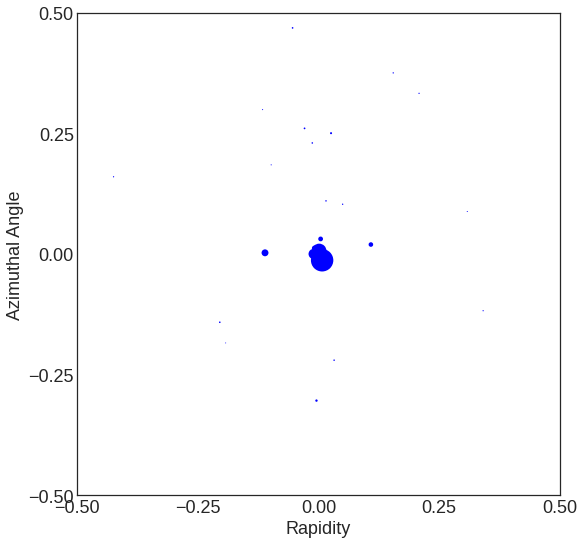

<AxesSubplot:xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [2]:
# Parameters
R = 0.5
beta = 1.0
N = 50
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"

dataset, sim_weights, sim_factors = load_cmsopendata("~/.energyflow/datasets/", "sim", pt_lower, pt_upper, eta, quality, pad, n = N)


example_event = dataset[0]
plot_event(example_event[0], example_event[1], R, color = "blue")

# Observables

### Common Observables

There are many predefined observables in the `SHAPER` framework. The function `buildCommonObservables` can be used to access them. To see the list of all pre-built observables, print the dictionary `commonObservables` (if you want a larger $N$, change the `N` parameter from `3`.). For now we will pick out two observables of interest as an example: `_3subjettiness` and `_3diskiness`.

Note that the object `pointers` is necessary to retain references to the pre-built observables. Do not delete it!

In [3]:
commonObservables, pointers = buildCommmonObservables(N = 3, beta = 1, R = R, device = device)
_3subjettiness = commonObservables["3-Subjettiness"]
_3diskiness= commonObservables["3-Diskiness"]

### Custom and Composite Observables

Now, we will construct some custom shape observables. A shape observable needs three major ingredients:
* A sampler function: This is a function that takes in an integer $N$ and a dictionary of parameters. It returns a list of points (usually $N$ of them, but not necessarily) and weights that depend on the parameters and in principle should approximate the shape. The determination of these functions are where the "science" occurs.
* A list of parameters: Shapes require parameters, which are used later for the sampler function. Parameters are/"live on" `Manifolds`, such as 2D coordinates, real numbers, simplexes, or circles (which are pre-defined, we won't worry about making new ones for now.). In the initialization of the observable, a dictionary of the form `{"Parameter Name": Manifold}` is required. Additionally, the parameters $\beta$ and $R$ are required. An initialization scheme for the parameters is also required, but by default this is set to `kt`.
* OPTIONALLY, a plotter function: `SHAPER` is capable of animating its own training process and producing event-by-event displays of shapes fitting onto events. These functions are used to render the shapes in `matplotlib`, which can be used to visualize individual shapes and is very useful for debugging custom shapes. However, this is often not necessary for physics analyses. 

We will show three custom observables. First, we construct an observable, isotropy, which measures how uniform an event is. Isotropy is unique observable, as it does not require any parameters, making it extremely simple. Second, we will construct the observaled "N-Point-Ellipsiness" (This observable *already* exists in commonObservables; this is for illustrative purposes), which measures how much the event looks like ellipses with delta functions at their centers. This has a highly nontrivial parameterization. Finally, we will build a composite observable, "N-Point-Ellipsiness Plus Pileup", which combines the previous two observables with the addition operator. For this last observable, we will also show how to construct the optional plotter (note that for N-Point-Ellipsiness, the prebuilt version already has a plotter)


In [4]:
from src.Manifolds import Coordinates2D, Simplex, PositiveReals, Circle
from matplotlib.patches import Rectangle as pltRectangle
from matplotlib.patches import Ellipse as pltEllipse


 
#####################
# #### Isotropy #####
#####################


# Sample from a normalized uniform distribution
def uniform_sampler(N, param_dict):
    points = torch.FloatTensor(N, 2).uniform_(-R, R).to(device)
    zs = torch.ones((N,)).to(device) / N
    return (points, zs)

_isotropy = Observable({}, uniform_sampler, beta = beta, R = R)



###############################
##### N-Point-Ellipsiness #####
###############################

# Sample points from N uniform ellipses plus weighted points at their center
def point_ellipse_sampler(N, param_dict):

    centers = param_dict["Points"].params
    num = param_dict["Points"].N
    radii1 = param_dict["Radius1"].params
    radii2 = param_dict["Radius2"].params
    angles = param_dict["Angles"].params
    weights = param_dict["Weights"].params

    phi = 2 * np.pi * torch.rand(num, N).to(device)
    r = torch.sqrt(torch.rand(num, N)).to(device)
    points = torch.stack([radii1[:, None] * torch.cos(phi + angles[:, None]), radii2[:, None] * torch.sin(phi + angles[:, None])], axis=1) * r[:, None, :] + centers[:, :, None]
    points = torch.cat([point for point in points], dim=1)

    # Concatenate and reweight
    e = torch.cat([centers, points.T], dim=0)
    z1 = torch.cat([weights[i] * torch.ones((1,), device=device) for i in range(num)], dim=0)
    z2 = torch.cat([weights[num + i] * torch.ones((N,), device=device) / N for i in range(num)], dim=0)
    z = torch.cat([z1, z2], dim=0)
    return (e, z)

_3pointellipsiness = Observable({"Points": Coordinates2D(3), "Weights": Simplex(2*3), "Radius1": PositiveReals(3, 0), "Radius2": PositiveReals(3, 0), "Angles": Circle(3, 0)}, point_ellipse_sampler, beta=1, R=R, initializer="kt")


################################
##### COMPOSITE OBSERVABLE #####
################################

# First, use the addition operator to join the two previous observables
_3pointellipsiness_pileup = _3pointellipsiness + _isotropy

# Change the initialization so that the initial relative energies of the two observables is 100-0 (default is 50-50)
_3pointellipsiness_pileup.params["Joint Weights"].default_value = torch.tensor([1.0,0.00])

# Define the plotter
def pileup_plotter(ax, param_dict):

    centers = param_dict["Points"].params.clone().detach().numpy()
    radii1 = param_dict["Radius1"].params.clone().detach().numpy()
    radii2 = param_dict["Radius2"].params.clone().detach().numpy()
    angles = param_dict["Angles"].params.clone().detach().numpy()
    weights = param_dict["Weights"].params.clone().detach().numpy() * param_dict["Joint Weights"].params.clone().detach().numpy()[0]
    num = param_dict["Points"].N
    pileup = param_dict["Joint Weights"].params.clone().detach().numpy()[1]

    for i in range(num):
        # Circle
        draw_circle = pltEllipse(centers[i,:], 2*radii1[i], 2*radii2[i], angle = angles[i] * 180 / np.pi, facecolor = "purple", edgecolor = "purple", alpha = 1.0 * weights[i+num], zorder = 12)
        ax.add_artist(draw_circle)

        draw_circle = pltEllipse(centers[i,:], 2*radii1[i], 2*radii2[i], angle = angles[i] * 180 / np.pi, facecolor = "none", edgecolor = "purple", alpha = 0.75)
        ax.add_artist(draw_circle)

        # Center
        ax.scatter(centers[i,0], centers[i,1], color = "Purple",  marker = "x", s = 2 * weights[i] * 500/np.sum(weights), alpha = 0.75, zorder = 15, lw = 3)
        
        # Text
        eccentricity = np.sqrt(1 - min(radii1[i], radii2[i]) / max(radii1[i], radii2[i]))
        if num > 1:
            s = "%d) " % (num - i)
        else:
            s = ""

        plt.text(0.05, 0.10 + 0.05*i, s + r"Eff. Rad: %.2f, Ecc: %.2f, z$_\delta$, z$_\mathcal{O}$: (%.2f, %.2f)" % (np.sqrt(radii1[i] * radii2[i]), eccentricity, weights[i], weights[i+num], ), fontsize = 18, transform = plt.gca().transAxes)

    plt.text(0.05, 0.10 + 0.05*num, r"z$_{PU}$: %.2f" % (pileup), fontsize = 18, transform = plt.gca().transAxes)
    draw_rect = pltRectangle( (-R*0.9, -R*0.9), 2*R*0.9, 2*R*0.9, angle = 0, facecolor = "purple", edgecolor = "purple", alpha = 0.50 * pileup)
    ax.add_artist(draw_rect)    


# Add the plotter
_3pointellipsiness_pileup.plotter = pileup_plotter



# SHAPER

Having defined observables, we can now calculate their values on our dataset using `SHAPER`. There are several options when using `SHAPER`:
* `epochs`, `early_stopping`, and `early_stopping_fraction`: The first parameter is the maximum number of epochs the algorithm is allowed to run. The second is how many epochs to wait without improvement to end the algorithm early (25 by default) for each event. If running on many events in a single batch, the last parameter is the fraction of events that need to be considered done (reached `early_stopping` epochs) before the algorithm finished (0.95 by default). It is useful to set this slghtly below 1.00, since there are always a handful of events that take a while to incrementally improve, but these events are "good enough" by the time the rest of the other 95% converge. 
* `N` (default is 100) is passed to each shape observable's sampler function. Typically, this is used to specify how many points should be randomly generated per shape, though this can be used for anything (or not at all) in custom samplers.
* `epsilon` (default is 0.001) is the Sinkhorn approximation parameter, and `scaling` (default is 0.9) is the annealing parameter. Both these parameters affect runtime versus precision. If using a GPU, it is highly recommended not to reduce epsilon below 0.001, as machine precision will negatively affect your results.
* `lr` (default is .01) is the learning rate for the ADAM optimizer, used to optimize shape parameters. As of `SHAPER v1.0.0`, ADAM is the only supported optimizer.
* `verbose` prints to the screen. If a `plot_dictionary` is specified, event displays for each event will be rendered and saved in `matplotlib` after training. If a shape observable has an associated plotter function, this will be used to render the shape on top of the event (useful for debugging and showing example results). If a gif directory is specified, an animation of the entire minimization process will be generated. Note that rendering is resource intensive and is only recommended to do for a small (ten or less) number of events at once.

`SHAPER` will process each observable one at a time. For each observable, `SHAPER` will process the entire batch of events in parallel. When running `SHAPER` with the `verbose` option, a new line will print for epoch, and print the percentage of events considered "done", as defined by the early stopping procedure. The percentage done will remain at 0% until at least `early_stopping` epochs have passed, after which it will begin to rise. It will continue to rise until either it reaches `early_stopping_fraction` or the total number of epochs reaches `epochs`, after which `SHAPER` will save the lowest EMDs and corresponding parameters for each event, and move on to the next observable. For trivial observables (those with no parameters, or all parameters frozen, such as isotropy), only a single epoch is required.

The running time will depend heavily on your computing architecture. If running on an old laptop CPU, this calculation should take less than 5 minutes for 50 events. If running on a GPU, which can be enabled as shown in the Imports section, it will be much faster, and the batch size can be considerably increased for a faster runtime per event.



In [5]:



# Collect our observables in one dictionary
observables = {}
observables["Isotropy"] = _isotropy
observables["3-Subjettiness"] = _3subjettiness
observables["3-Diskiness"] = _3diskiness
observables["3-Point-Ellipsiness"] = _3pointellipsiness
observables["3-Point-Ellipsiness-Plus-Pileup"] = _3pointellipsiness_pileup

# Initialize SHAPER
shaper = Shaper(observables, device)
shaper.to(device)


# Run SHAPER on a single event, saving a training animation (Note that observables with no plotter will look blank)
plot_dictionary = {
    "plot_directory" : "Plots/Test",
    "gif_directory" : "Plots/Test/gifs",  
    "extension" : "png",
    "title" : "SIM Jets"
}
emds, params = shaper.calculate(dataset[0], epochs = 500, verbose=True, lr = 0.01, N = 100, scaling = 0.9, epsilon = 0.001, early_stopping= 25, early_stopping_fraction = 0.95, plot_dictionary=plot_dictionary)





# Run SHAPER in batches, and save outputs, without plotting (much faster)

batch_size = N + 1 # Run for a single batch
batches = int(N / batch_size) + 1

for batch in range(batches):

    print("BATCH: %d" % batch)
    start = batch * batch_size
    end = (batch + 1) * batch_size

    dataset_emds, dataset_params = shaper.calculate(dataset[start:end], epochs = 500, verbose=True, lr = 0.01, N = 50, scaling = 0.9, epsilon = 0.001, early_stopping= 25)



Observable: Isotropy Mean Loss = 0.7055757
Observable: 3-Subjettiness Epoch 0 Mean Loss = 0.0429934598505497 Elapsed time = 0.655s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 1 Mean Loss = 0.04262998700141907 Elapsed time = 0.880s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 2 Mean Loss = 0.04045112431049347 Elapsed time = 1.105s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 3 Mean Loss = 0.03775645047426224 Elapsed time = 1.322s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 4 Mean Loss = 0.03653375804424286 Elapsed time = 1.531s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 5 Mean Loss = 0.03644748032093048 Elapsed time = 1.737s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 6 Mean Loss = 0.03623494878411293 Elapsed time = 1.946s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 7 Mean Loss = 0.03499894589185715 Elapsed time = 2.164s Percentage done = 0.000 
Observable: 3-Subjettiness Epoch 8 Mean Loss =

/tmp/ipykernel_8698/158567289.py:84: RuntimeWarning: invalid value encountered in float_scalars
  eccentricity = np.sqrt(1 - min(radii1[i], radii2[i]) / max(radii1[i], radii2[i]))


Observable: 3-Point-Ellipsiness-Plus-Pileup Epoch 0 Mean Loss = 0.0429934598505497 Elapsed time = 0.352s Percentage done = 0.000 
Observable: 3-Point-Ellipsiness-Plus-Pileup Epoch 1 Mean Loss = 0.0365009531378746 Elapsed time = 0.675s Percentage done = 0.000 
Observable: 3-Point-Ellipsiness-Plus-Pileup Epoch 2 Mean Loss = 0.03190182149410248 Elapsed time = 1.011s Percentage done = 0.000 
Observable: 3-Point-Ellipsiness-Plus-Pileup Epoch 3 Mean Loss = 0.03354828432202339 Elapsed time = 1.340s Percentage done = 0.000 
Observable: 3-Point-Ellipsiness-Plus-Pileup Epoch 4 Mean Loss = 0.029720071703195572 Elapsed time = 1.638s Percentage done = 0.000 
Observable: 3-Point-Ellipsiness-Plus-Pileup Epoch 5 Mean Loss = 0.028578734025359154 Elapsed time = 1.928s Percentage done = 0.000 
Observable: 3-Point-Ellipsiness-Plus-Pileup Epoch 6 Mean Loss = 0.02568993717432022 Elapsed time = 2.216s Percentage done = 0.000 
Observable: 3-Point-Ellipsiness-Plus-Pileup Epoch 7 Mean Loss = 0.03245288506150246

# Plots


Now that we have some results, we can plot the observables. We can plot the EMDs, the parameters, or arbitrary functions of them. Below is a generic function useful for histogramming shape parameters, EMDs, or even functions of shape parameters and EMDs. We will use this to plot the minimum and maximum eccentricities of the ellipse observables, as well as the EMDs for each observable.

/tmp/ipykernel_9272/1346221244.py:68: RuntimeWarning: invalid value encountered in true_divide
  e = np.sqrt(1 - np.nan_to_num(np.minimum(a, b) / np.maximum(a,b)))


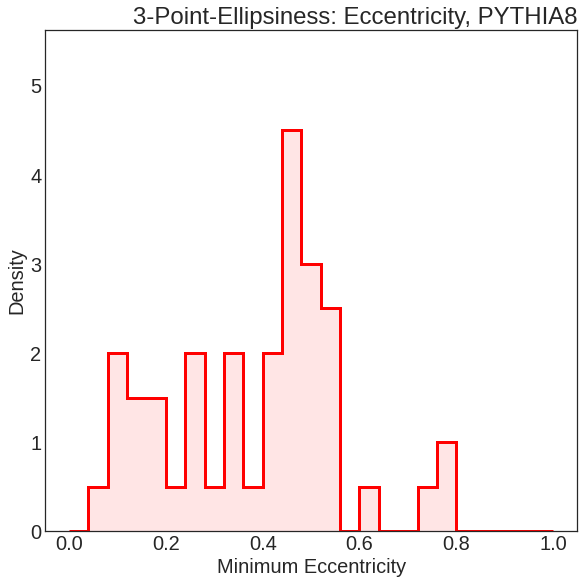

/tmp/ipykernel_9272/1346221244.py:74: RuntimeWarning: invalid value encountered in true_divide
  e = np.sqrt(1 - np.nan_to_num(np.minimum(a, b) / np.maximum(a,b)))


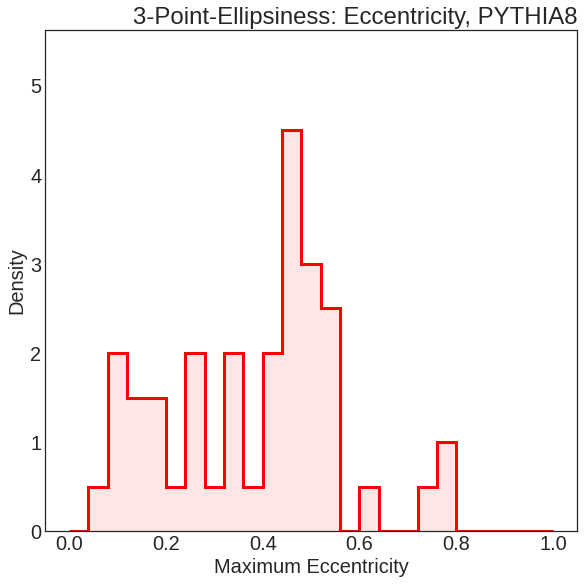

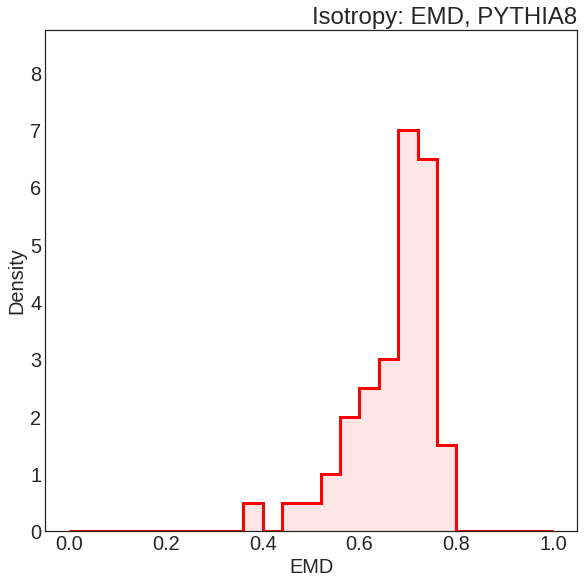

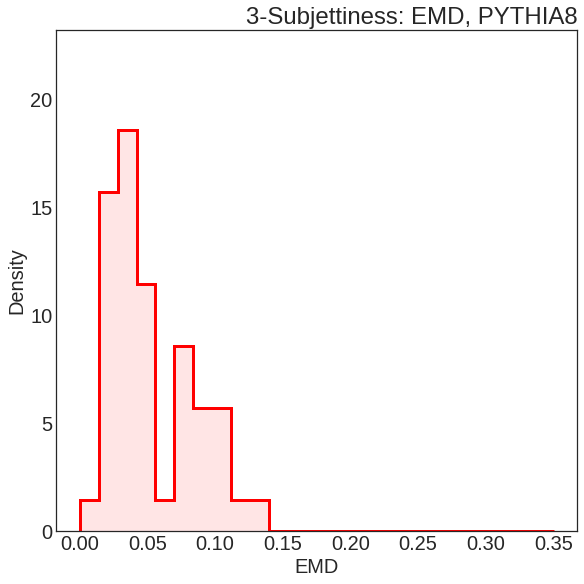

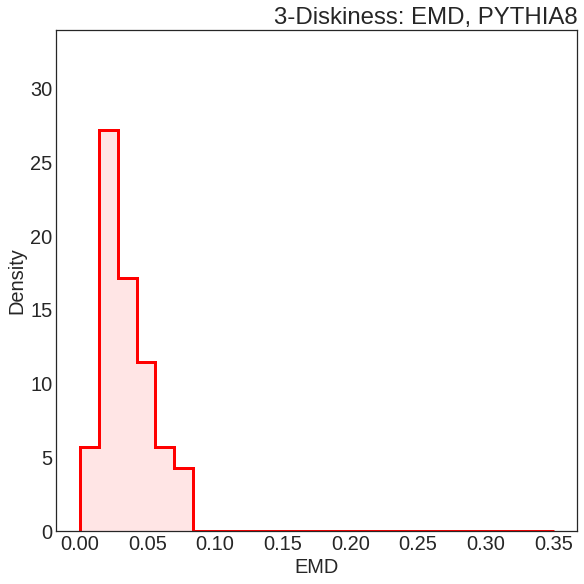

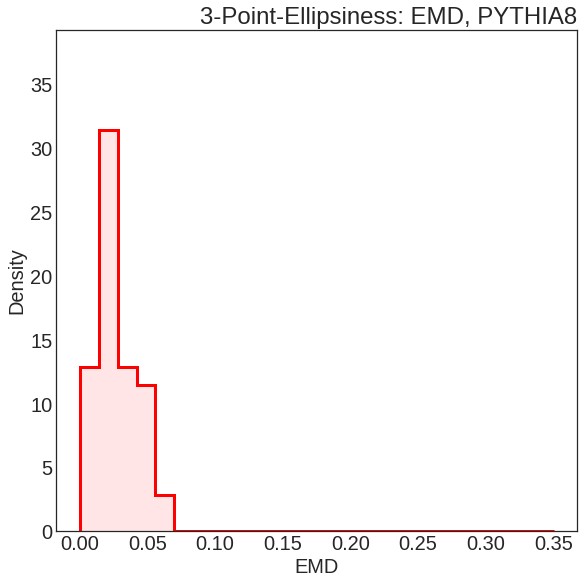

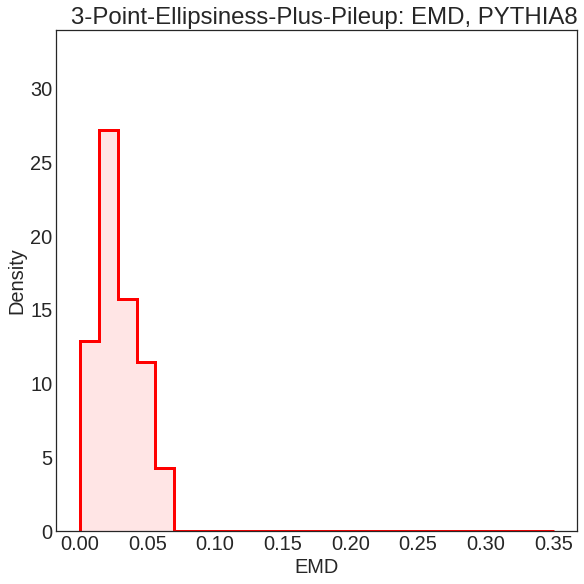

In [ ]:
from matplotlib.patches import Patch


dataset_emds, dataset_params 

# Function to make plots of params
def plot_observable_param(obs, param, xlim, function = None, xlabel = None, complex_function = None):

    plt.rcParams.update({'font.size': 20})
    fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))

    bins = 25
    sg = []

    if param == "EMD":
        for i in range(N):
            sg.append((dataset_emds[obs][i]))

    else:
        
        for i in range(N):

            if complex_function is not None:
                sg.append(complex_function(dataset_params, obs, i))

            elif function is None:

                sg.append(dataset_params[obs][i][param])

            else:

                sg.append(function(dataset_params[obs][i]))
            

    sg = np.array(sg)
    s_counts, s_bins, _ =plt.hist(sg, bins = bins, range = xlim, density = True, lw = 3, color = "red", histtype="step", label = "SIM Jets")

    # for style, fill in hists
    plt.hist(sg, bins = bins, range = xlim, density = True, lw = 3, color = "red", histtype="stepfilled", alpha = 0.1)


    # Cosmetics
    legend_elements = [Patch(facecolor= (0,0,1,0.1), edgecolor='b', lw = 2, label='QCD Jets'),
                       Patch(facecolor= (1,0,0,0.1), edgecolor='r', lw = 2, label='Top Jets')]


    s_max = max(s_counts)
    y_lim = s_max * 1.25
    plt.ylim(0, y_lim)


    plt.xlabel(param)
    if xlabel is not None:
        plt.xlabel(xlabel)
    plt.ylabel("Density")
    plt.title("%s: %s, PYTHIA8" % (obs, param), loc = "right")

    plt.savefig("Plots/Parameters/parameters_%s_%s.pdf" % (obs, param))
    plt.show()
    plt.close()




def min_eccentricity(param_dict):
    a = param_dict["Radius1"]
    b = param_dict["Radius2"]
    e = np.sqrt(1 - np.nan_to_num(np.minimum(a, b) / np.maximum(a,b)))
    return np.amin(e)

def max_eccentricity(param_dict):
    a = param_dict["Radius1"]
    b = param_dict["Radius2"]
    e = np.sqrt(1 - np.nan_to_num(np.minimum(a, b) / np.maximum(a,b)))
    return np.amax(e)



plot_observable_param("3-Point-Ellipsiness", "Eccentricity", [0,1.0], min_eccentricity, xlabel = "Minimum Eccentricity")
plot_observable_param("3-Point-Ellipsiness", "Eccentricity", [0,1.0], max_eccentricity, xlabel = "Maximum Eccentricity")


# Plot all EMDS:
for obs in observables:
    if obs == "Isotropy":
        plot_observable_param(obs, "EMD", [0, 1.0])
    else:
        plot_observable_param(obs, "EMD", [0, 0.350])


